In [1]:
import sys
sys.path.append('..')

../00000/*.png


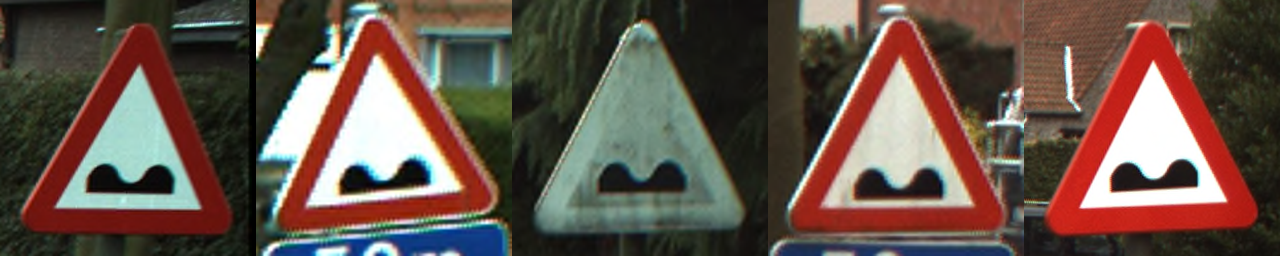

In [2]:
local_dir = "../00000/" #@param

from PIL import Image

from config import image_grid
import glob

# change path to display images from your local dir
img_paths = f"../{local_dir.split('/')[1]}/*.png"
print(img_paths)
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [3]:
# import requests
# from transformers import AutoProcessor, BlipForConditionalGeneration
# import torch

#### Loading the BLIP processor and captioning model

In [4]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

In [5]:
# def caption_images(input_image):
#     inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
#     pixel_values = inputs.pixel_values

#     generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
#     generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
#     return generated_caption

In [6]:
# import glob
# from PIL import Image
# imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.png")]

# import json

# caption_prefix = "a photo of TOK traffic sign, 00000 with "
# with open(f'{local_dir}/metadata.jsonl', 'w') as outfile:
#   for img in imgs_and_paths:
#       caption = caption_prefix + caption_images(img[1]).split("\n")[0]
#       entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
#       json.dump(entry, outfile)
#       outfile.write('\n')

In [7]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

Configuration already exists at /home/khanhnq/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [8]:
from huggingface_hub import login
import os
import dotenv

dotenv.load_dotenv()
TOKEN = os.getenv("HUGGINGFACE_TOKEN")

login(token=TOKEN)


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/khanhnq/.cache/huggingface/token
Login successful


In [10]:
from huggingface_hub import notebook_login
notebook_login()

In [11]:
import wandb
KEY = os.getenv("WANDB_API_KEY")
wandb.login(key=KEY)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: qkhanh711. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/khanhnq/.netrc


True

In [1]:
!accelerate launch ../diffuserss/train_dreambooth_lora_flux.py \
  --pretrained_model_name_or_path="black-forest-labs/FLUX.1-dev" \
  --instance_data_dir="../00000" \
  --output_dir="LoRA_flux" \
  --mixed_precision="bf16" \
  --instance_prompt="a photo of TOK traffic sign ID 00000 with ocean waves in background" \
  --resolution=64 \
  --train_batch_size=1 \
  --guidance_scale=1 \
  --gradient_accumulation_steps=4 \
  --optimizer="prodigy" \
  --learning_rate=1. \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=5 \
  --validation_prompt="A photo of TOK traffic sign ID 00000 with ocean waves in background" \
  --validation_epochs=25 \
  --seed="0" \
  # --push_to_hub

/home/khanhnq/anaconda3/envs/GAI/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/khanhnq/anaconda3/envs/GAI/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2024-09-17 09:26:44.662579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 09:26:44.714014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU in

### Saving the model to repo in HuggingFace

In [3]:
from huggingface_hub import whoami
from pathlib import Path
output_dir = "00000_LoRA_flux" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"
print(f"Your model is available at https://huggingface.co/{repo_id}")

Your model is available at https://huggingface.co/Nyanmaru/00000_LoRA_flux


In [6]:
# change the params below according to your training arguments
from diffuserss import train_flux
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
train_flux(
    repo_id = repo_id,
    images=[],
    base_model="black-forest-labs/FLUX.1-dev",
    train_text_encoder=False,
    instance_prompt="a photo of TOK traffic sign, 00000",
    validation_prompt=None,
    repo_folder=output_dir,
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

CommitInfo(commit_url='https://huggingface.co/Nyanmaru/00000_LoRA_flux/commit/e6ace30b9a34fd8ceb6f499dc48fdc8ca0c74489', commit_message='End of training', commit_description='', oid='e6ace30b9a34fd8ceb6f499dc48fdc8ca0c74489', pr_url=None, pr_revision=None, pr_num=None)

In [7]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/Nyanmaru/00000_LoRA_flux